
# Classificador de Risco de Sintomas (Triagem Clínica)
Este notebook constrói um **classificador binário** que analisa frases com sintomas e classifica o nível de risco como **“baixo risco”** ou **“alto risco”**.

**Pipeline em alto nível:**
1. Carrega o dataset CSV de frases rotuladas.
2. Pré-processa e filtra as classes de interesse.
3. Transforma texto em vetores com **TF‑IDF**.
4. Treina um modelo de **Regressão Logística**.
5. Avalia o desempenho (acurácia, relatório de classificação, matriz de confusão).
6. Testa frases novas e inspeciona erros para observar padrões/distorções.



## (Opcional) Instalação de dependências
> Execute **apenas se necessário** no seu ambiente local (ex.: Google Colab).  
Se as bibliotecas já estiverem disponíveis, podemos **pular** esta etapa.


In [1]:

# Descomente se precisar instalar
%pip install -q scikit-learn pandas matplotlib


Note: you may need to restart the kernel to use updated packages.



## Imports e configuração


In [2]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42



## Carga do dataset com as frases rotuladas
- O arquivo `frases_medicas_rotuladas.csv` precisa estar **na mesma pasta** deste notebook **ou** para funcionar!


In [3]:
df = pd.read_csv(Path('frases_medicas_rotuladas.csv'))
print(f"Linhas: {len(df)}")
df.head()


Linhas: 400


,frase,situacao
0,nos últimos dias tive febre alta e calafrios f...,alto risco
1,hoje sinto dor no peito e falta de ar desde cedo,alto risco
2,hoje me sinto cansado mas sem dor e estou preo...,baixo risco
3,ultimamente estou com sangramento intenso,alto risco
4,sinto dor de cabeça leve ocasionalmente e pior...,baixo risco


In [4]:

df = df[df["situacao"].isin(["baixo risco", "alto risco"])].copy()
df["situacao"] = df["situacao"].astype(str)

print("Distribuição de classes:")
print(df["situacao"].value_counts())

df.sample(min(5, len(df)), random_state=RANDOM_STATE)


Distribuição de classes:
situacao
alto risco     200
baixo risco    200
Name: count, dtype: int64


,frase,situacao
209,ultimamente tenho dor leve nas articulações ma...,baixo risco
280,tenho dor leve nas articulações desde cedo,baixo risco
33,ultimamente tive febre baixa durante a noite,baixo risco
210,hoje tive dificuldade para respirar subitament...,alto risco
93,hoje tive visão turva e tontura súbita,alto risco



## Divisão do dataset em treino e teste (antes da vetorização)
Dividimos **texto cru** para preservar os índices e facilitar análises posteriores de erros.


In [5]:

X_text = df["frase"].astype(str)
y = df["situacao"]

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

len(X_train_text), len(X_test_text)


(280, 120)


## Vetorização com TF‑IDF
Utilizamos **TF‑IDF** para converter texto em vetores numéricos. O uso de **unigramas e bigramas** captura termos e pequenas expressões (ex.: *"dor no peito"*).


In [6]:

vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

X_train.shape, X_test.shape


((280, 270), (120, 270))


## Modelo escolhido: Regressão Logística
**Por que Regressão Logística?**
- Problema **binário** (alto vs baixo risco) — a RL é uma escolha clássica e eficiente.
- É rápida de treinar e fornece **probabilidades**, úteis para triagem (priorizar casos mais prováveis de alto risco).
- Árvores de decisão podem superajustar em textos curtos; SVM e Naive Bayes também são boas alternativas, mas mantemos a RL pela **simplicidade, desempenho e interpretabilidade**.


In [7]:

model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predições e probabilidades
y_pred = model.predict(X_test)

# Índice da classe 'alto risco' no vetor de probabilidades
idx_alto = list(model.classes_).index("alto risco")
y_proba_alto = model.predict_proba(X_test)[:, idx_alto]

acc = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acc:.3f}\n")
print("Relatório de classificação:")
print(classification_report(y_test, y_pred, digits=3))


Acurácia: 1.000

Relatório de classificação:
              precision    recall  f1-score   support

  alto risco      1.000     1.000     1.000        60
 baixo risco      1.000     1.000     1.000        60

    accuracy                          1.000       120
   macro avg      1.000     1.000     1.000       120
weighted avg      1.000     1.000     1.000       120




## Matriz de Confusão
A matriz nos ajuda a entender **acertos** e **erros** por classe.


In [8]:

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm


array([[60,  0],
       [ 0, 60]])

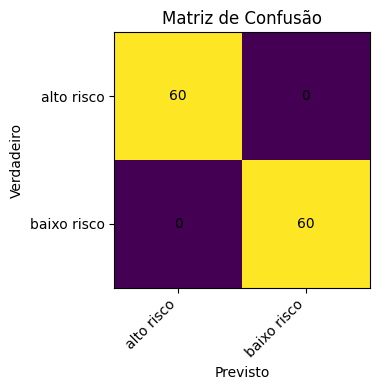

In [9]:

# Plot simples (sem estilos/cores específicas)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm)  # não especificar cmap
ax.set_xticks(range(len(model.classes_)))
ax.set_yticks(range(len(model.classes_)))
ax.set_xticklabels(model.classes_, rotation=45, ha="right")
ax.set_yticklabels(model.classes_)

# Anotações nos blocos
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i, j]), ha="center", va="center")

ax.set_xlabel("Previsto")
ax.set_ylabel("Verdadeiro")
ax.set_title("Matriz de Confusão")
plt.tight_layout()
plt.show()



## Inspeção de erros e possíveis padrões
Juntamos as frases de teste, rótulos verdadeiros, predições e a probabilidade de **alto risco** para inspecionar **falsos positivos/negativos**.


In [10]:

resultados = pd.DataFrame({
    "frase": X_test_text.values,
    "verdadeiro": y_test.values,
    "previsto": y_pred,
    "prob_alto_risco": y_proba_alto
})

# Erros
erros = resultados[resultados["verdadeiro"] != resultados["previsto"]]
print("Total de erros:", len(erros))
resultados.sample(10, random_state=RANDOM_STATE)


Total de erros: 0


,frase,verdadeiro,previsto,prob_alto_risco
44,sinto dor de cabeça leve ocasionalmente e pior...,baixo risco,baixo risco,0.134264
47,nos últimos dias tive um leve incômodo nas cos...,baixo risco,baixo risco,0.179730
4,ultimamente estou com coriza e espirros,baixo risco,baixo risco,0.199231
55,desde ontem tenho tosse seca sem febre mas sem...,baixo risco,baixo risco,0.153851
26,nos últimos dias tive um leve incômodo nas cos...,baixo risco,baixo risco,0.167418
64,hoje me sinto cansado mas sem dor e piorou agora,baixo risco,baixo risco,0.204414
73,estou com sangramento intenso e piorou agora,alto risco,alto risco,0.791784
10,tive febre baixa durante a noite desde cedo,baixo risco,baixo risco,0.170305
40,desde ontem sinto leve dor de garganta mas sem...,baixo risco,baixo risco,0.169203
107,sinto dor abdominal forte e náusea mas sem out...,alto risco,alto risco,0.809663


In [11]:

# Visualizar apenas os erros (se houver)
erros if len(erros) else "Nenhum erro encontrado."


'Nenhum erro encontrado.'


## Testes com frases novas (exemplos)


In [12]:

novas_frases = [
    "sinto dor no peito e falta de ar",
    "tive uma leve dor de cabeça",
    "vômito com sangue e tontura",
    "pressão no peito ao subir escadas",
]

X_new = vectorizer.transform(novas_frases)
pred_new = model.predict(X_new)
proba_new = model.predict_proba(X_new)[:, idx_alto]

for frase, pred, p in zip(novas_frases, pred_new, proba_new):
    print(f'"{frase}" -> {pred} (prob_alto_risco={p:.2f})')


"sinto dor no peito e falta de ar" -> alto risco (prob_alto_risco=0.82)
"tive uma leve dor de cabeça" -> baixo risco (prob_alto_risco=0.15)
"vômito com sangue e tontura" -> alto risco (prob_alto_risco=0.60)
"pressão no peito ao subir escadas" -> alto risco (prob_alto_risco=0.77)



## (Opcional) Salvar modelo e vetorizador
Caso queira reutilizar o classificador sem re-treinar.


In [ ]:

# from joblib import dump
# dump(model, "modelo_triagem_logreg.pkl")
# dump(vectorizer, "tfidf_vectorizer.pkl")
# print("Artefatos salvos no diretório do notebook.")



## Conclusões e próximos passos
- **Tamanho/qualidade do dataset** impacta fortemente o desempenho — Não está muito claro para nós como definir um tamanho ideal de base para uma solução de produção, tendo em vista que uma base muito pequena não fornece amostragem suficiente para o modelo, enquanto uma base muito grande pode enviesar/viciar o modelo durante o treinamento, obtendo resultados "perfeitos", tendo em vista que todas as combinações possíveis de frases de sintomas já teriam sido utilizadas. Aqui foram utilizadas frases geradas pelo ChatGPT, e revisadas superficialmente. Porém, o ideal seria trabalhar com uma base de dados real, com relatos reais de pacientes.

- Considerar **balancear classes** (ex.: `class_weight='balanced'` na Regressão Logística) quando houver desbalanceamento, o que não foi o caso aqui, mas pode ser necessário em bases reais.

- Avaliar alternativas como **Naive Bayes** e **SVM** para comparação. Como o enunciado da atividade não pede uma comparação direta entre diferentes modelos, optamos por não fazer, mas esse seria um passo extra interessante, a fim de avaliar como cada modelo desempenharia nesse mesmo cenário.
